In [1]:
!pip install h2o
%matplotlib inline
import random, os, sys
import h2o
import pandas
import pprint
import operator
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [2]:
#Connect to a cluster or initialize it if not started
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)
  Starting server from C:\Users\HP\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\HP\AppData\Local\Temp\tmphyu3ehn_
  JVM stdout: C:\Users\HP\AppData\Local\Temp\tmphyu3ehn_\h2o_HP_started_from_python.out
  JVM stderr: C:\Users\HP\AppData\Local\Temp\tmphyu3ehn_\h2o_HP_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_HP_r9oxf4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.939 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [4]:
data = h2o.import_file( 'https://raw.githubusercontent.com/aiskunks/The_Economics_of_Happiness/main/TEH/TEH_World_Happiness_2015_2019.csv' )


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
data.describe()

Rows:782
Cols:10

,Country,Happiness rank,Happiness Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Year
type,enum,int,real,real,real,real,real,real,real,int
mins,,1.0,2.693000078,0.0,0.0,0.0,0.0,0.0,0.0,2015.0
mean,,78.69820971867004,5.379017902998721,0.9160474824757038,1.0783924825089533,0.6124155771253205,0.4110908258235294,0.21857584156138085,0.12527520997058825,2016.9936061381088
maxs,,158.0,7.769,2.096,1.644,1.141,0.724,0.838075161,0.55191,2019.0
sigma,,45.18238438270533,1.1274564601618513,0.4073401312916095,0.32954831933364276,0.2483086403761213,0.15288042062428447,0.12232074872244174,0.10584377164077122,1.4173644324240484
zeros,,0,0,5,5,5,5,5,7,0
missing,0,0,0,0,0,0,0,0,0,0
0,Switzerland,1.0,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,2015.0
1,Iceland,2.0,7.561,1.30232,1.40223,0.94784,0.62877,0.4363,0.14145,2015.0
2,Denmark,3.0,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,2015.0


In [6]:

# Data exploration and munging. Generate scatter plots 

def scatter_plot(data, x, y, max_points = 1000, fit = True):
    if(fit):
        lr = H2OGeneralizedLinearEstimator(family = "gaussian")
        lr.train(x=x, y=y, training_frame=data)
        coeff = lr.coef()
    df = data[[x,y]]
    runif = df[y].runif()
    df_subset = df[runif < float(max_points)/data.nrow]
    df_py = h2o.as_list(df_subset)
    
    if(fit): h2o.remove(lr._id)

    # If x variable is string, generate box-and-whisker plot
    if(df_py[x].dtype == "object"):
        if interactive: df_py.boxplot(column = y, by = x)
    # Otherwise, generate a scatter plot
    else:
        if interactive: df_py.plot(x = x, y = y, kind = "scatter")
    
    if(fit):
        x_min = min(df_py[x])
        x_max = max(df_py[x])
        y_min = coeff["Intercept"] + coeff[x]*x_min
        y_max = coeff["Intercept"] + coeff[x]*x_max
        plt.plot([x_min, x_max], [y_min, y_max], "k-")
    if interactive: plt.show()


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


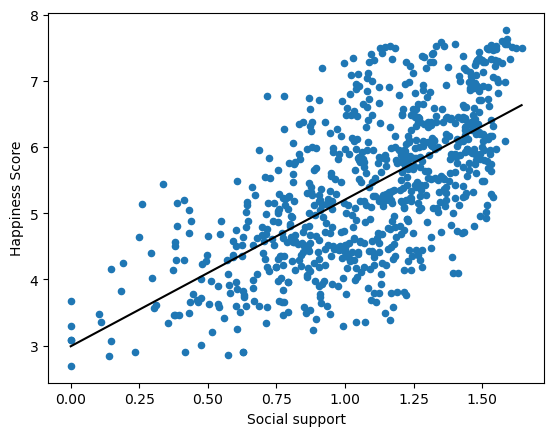

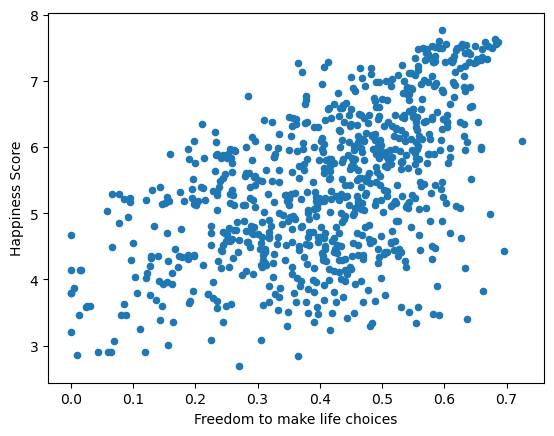

In [7]:
scatter_plot(data, "Social support", "Happiness Score", fit = True)
scatter_plot(data, "Freedom to make life choices", "Happiness Score", max_points = 5000, fit = False)

In [9]:
# Use the .group_by function to countries Happiness Score
grouped = data.group_by("Country")
bpd = grouped.count().sum("Happiness Score").frame
bpd.show()
bpd.describe()
bpd.dim

Country,nrow,sum_Happiness Score
Afghanistan,5,17.564
Albania,5,23.563
Algeria,5,28.338
Angola,4,15.489
Argentina,5,32.297
Armenia,5,21.966
Australia,5,36.381
Austria,5,35.71
Azerbaijan,5,26.146
Bahrain,5,30.569


Rows:170
Cols:3

,Country,nrow,sum_Happiness Score
type,enum,int,real
mins,,1.0,4.369
mean,,4.600000000000003,24.743482353794132
maxs,,5.0,37.729999836
sigma,,1.034322234705945,7.746500942954382
zeros,,0,0
missing,0,0,0
0,Afghanistan,5.0,17.56399991
1,Albania,5.0,23.563000053000003
2,Algeria,5.0,28.338000217


[170, 3]

In [10]:
# Create a test/train split
train,test = data.split_frame([.9])

In [17]:
#  Set response variable and your choice of predictor variables
myY = "Happiness Score"
myX = ["Happiness rank","GDP per capita","Social support","Healthy life expectancy","Freedom to make life choices","Generosity","Perceptions of corruption"]

In [19]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1668279724850_6


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.002218 )  7                             6                              1                       py_10_sid_b9da

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.017347092083856916
RMSE: 0.13170835996191327
MAE: 0.09957892397559193
RMSLE: 0.02359547836367822
Mean Residual Deviance: 0.017347092083856916
R^2: 0.9861248580562413
Null degrees of freedom: 704
Residual degrees of freedom: 698
Null deviance: 881.4107969987855
Residual deviance: 12.229699919119126
AIC: -841.5995930412938

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.026035052804835083
RMSE: 0.161353812489309
MAE: 0.10551623644238105
RMSLE: 0.03447145197220333
Mean Residual Deviance: 0.026035052804835083
R^2: 0.9809917104870913
Null degrees of freedom: 76
Residual degrees of freedom: 70
Null deviance: 112.00796511005369
Residual deviance: 2.0046990659723014
AIC: -46.403448625602174

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse        training_deviance     training_mae         training_r2         validation_rmse    validation_deviance    validation_mae       validation_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -------------------  --------------------  -------------------  ------------------  -----------------  ---------------------  -------------------  ------------------
    2022-11-12 14:30:19  0.000 sec   0             881.4107956672075          1.250228078960578
    2022-11-12 14:30:19  0.009 sec   1                                                           0.13170835996191327  0.017347092083856916  0.09957892397559193  0.9861248580562413  0.161353812489309  0.026035052804835083   0.10551623644238105  0.9809917104870913

Variable Importances: 
variable                      relative_importance    scaled_importance    percentage
----------------------------  ---------------------  -------------------  ------------
Happiness rank                1.07057                1                    0.926085
Perceptions of corruption     0.0323424              0.0302103            0.0279773
Social support                0.0164376              0.015354             0.0142191
Generosity                    0.0161324              0.0150689            0.0139551
Healthy life expectancy       0.01196                0.0111715            0.0103458
Freedom to make life choices  0.008575               0.00800972           0.00741768
GDP per capita                0                      0                    0

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [21]:
# Build simple GBM model

data_gbm = H2OGradientBoostingEstimator(balance_classes=True,
                                        ntrees         =10,
                                        max_depth      =1,
                                        learn_rate     =0.1,
                                        min_rows       =2)

data_gbm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,10.0,10.0,830.0,1.0,1.0,1.0,2.0,2.0,2.0
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2022-11-12 14:31:42,0.000 sec,0.0,1.1181360,0.9356804,1.2502281,1.2060883,0.9738751,1.4546489
,2022-11-12 14:31:42,0.070 sec,1.0,1.0410884,0.8471589,1.0838651,1.1335293,0.8947766,1.2848887
,2022-11-12 14:31:42,0.086 sec,2.0,0.9735621,0.7706850,0.9478232,1.0676466,0.8233360,1.1398692
,2022-11-12 14:31:42,0.101 sec,3.0,0.9132808,0.7075137,0.8340818,1.0127521,0.7705471,1.0256669
,2022-11-12 14:31:42,0.101 sec,4.0,0.8576175,0.6503492,0.7355078,0.9538348,0.7147172,0.9098008
,2022-11-12 14:31:42,0.116 sec,5.0,0.8077482,0.6072084,0.6524571,0.9111867,0.6796727,0.8302612
,2022-11-12 14:31:42,0.117 sec,6.0,0.7615259,0.5612992,0.5799217,0.8609131,0.6343772,0.7411714
,2022-11-12 14:31:42,0.117 sec,7.0,0.7196520,0.5286959,0.5178990,0.8262218,0.6077797,0.6826425


In [22]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GLM coefficients
from six import iteritems
glm_varimp = data_glm.coef_norm()
for k,v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])
    
# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key = operator.itemgetter(1), reverse = True)
table = tabulate(glm_sorted, headers = ["Predictor", "Normalized Coefficient"], tablefmt = "orgtbl")
print("Variable Importances:\n\n" + table)

data_glm.varimp()
data_gbm.varimp()

Variable Importances:

| Predictor                    |   Normalized Coefficient |
|------------------------------+--------------------------|
| Intercept                    |                5.40772   |
| Happiness rank               |                1.07057   |
| Perceptions of corruption    |                0.0323424 |
| Social support               |                0.0164376 |
| Generosity                   |                0.0161324 |
| Healthy life expectancy      |                0.01196   |
| Freedom to make life choices |                0.008575  |
| GDP per capita               |                0         |


[('Happiness rank', 3246.132080078125, 1.0, 1.0),
 ('GDP per capita', 0.0, 0.0, 0.0),
 ('Social support', 0.0, 0.0, 0.0),
 ('Healthy life expectancy', 0.0, 0.0, 0.0),
 ('Freedom to make life choices', 0.0, 0.0, 0.0),
 ('Generosity', 0.0, 0.0, 0.0),
 ('Perceptions of corruption', 0.0, 0.0, 0.0)]

In [23]:
dir(data_glm)

['HGLM',
 'Lambda',
 '_H2OEstimator__default_params',
 '_ModelBase__generate_partial_plots',
 '_ModelBase__generate_user_splits',
 '_ModelBase__grab_values',
 '_ModelBase__plot_1d_pdp',
 '_ModelBase__plot_1d_pdp_multinomial',
 '_ModelBase__plot_2d_pdp',
 '_ModelBase__pred_for_3d',
 '_ModelBase__set_axs_1d',
 '_ModelBase__set_axs_1d_multinomial',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_allowed_metrics',
 '_allowed_metrics_',
 '_bc',
 '_bci',
 '_check_and_save_parm',
 '_check_targets',
 '_default_metric',
 '_default_metrics_',
 '_default_param_value',
 '_end_time',
 '_estimator_type',
 '_fillMultinomialDict',
 '_future',
 '_get_m

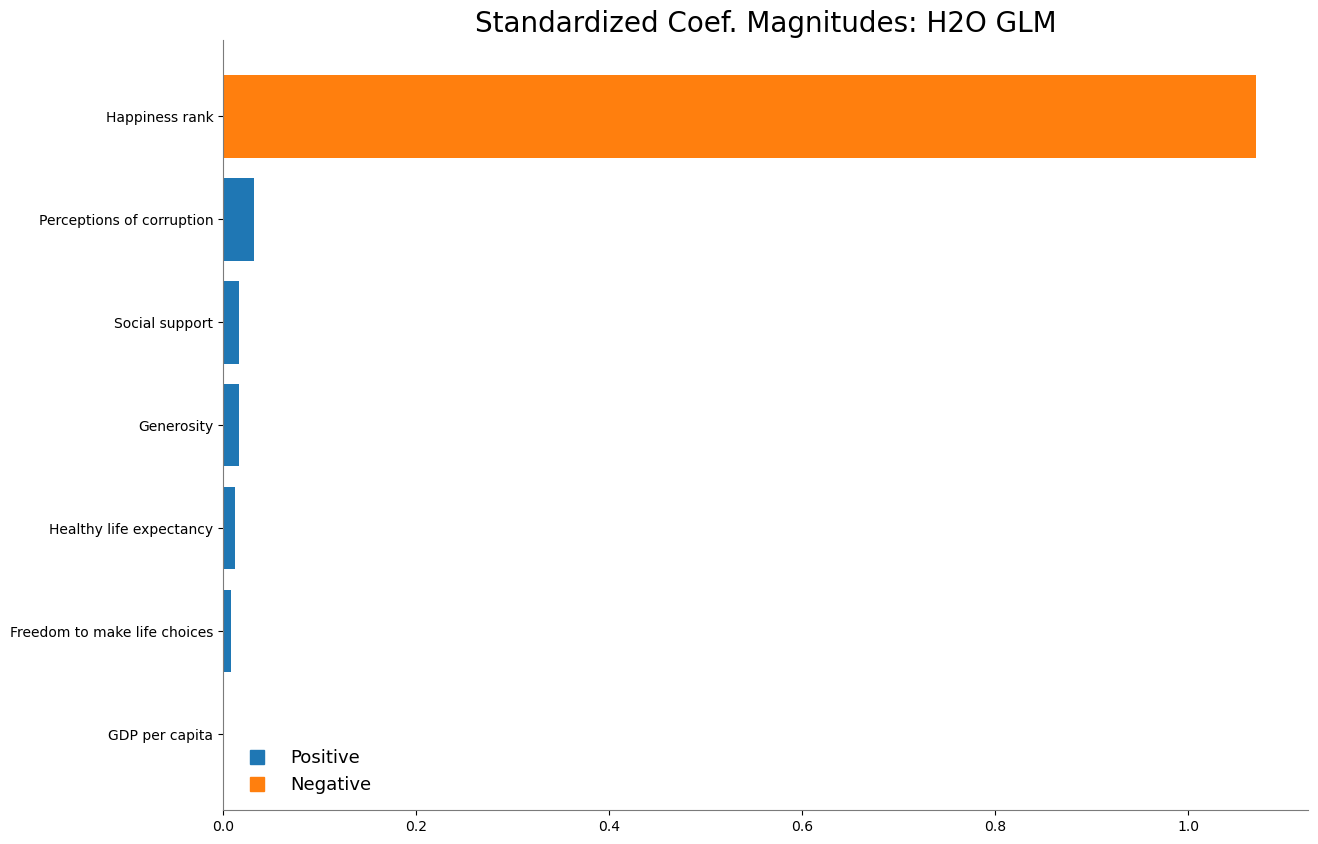

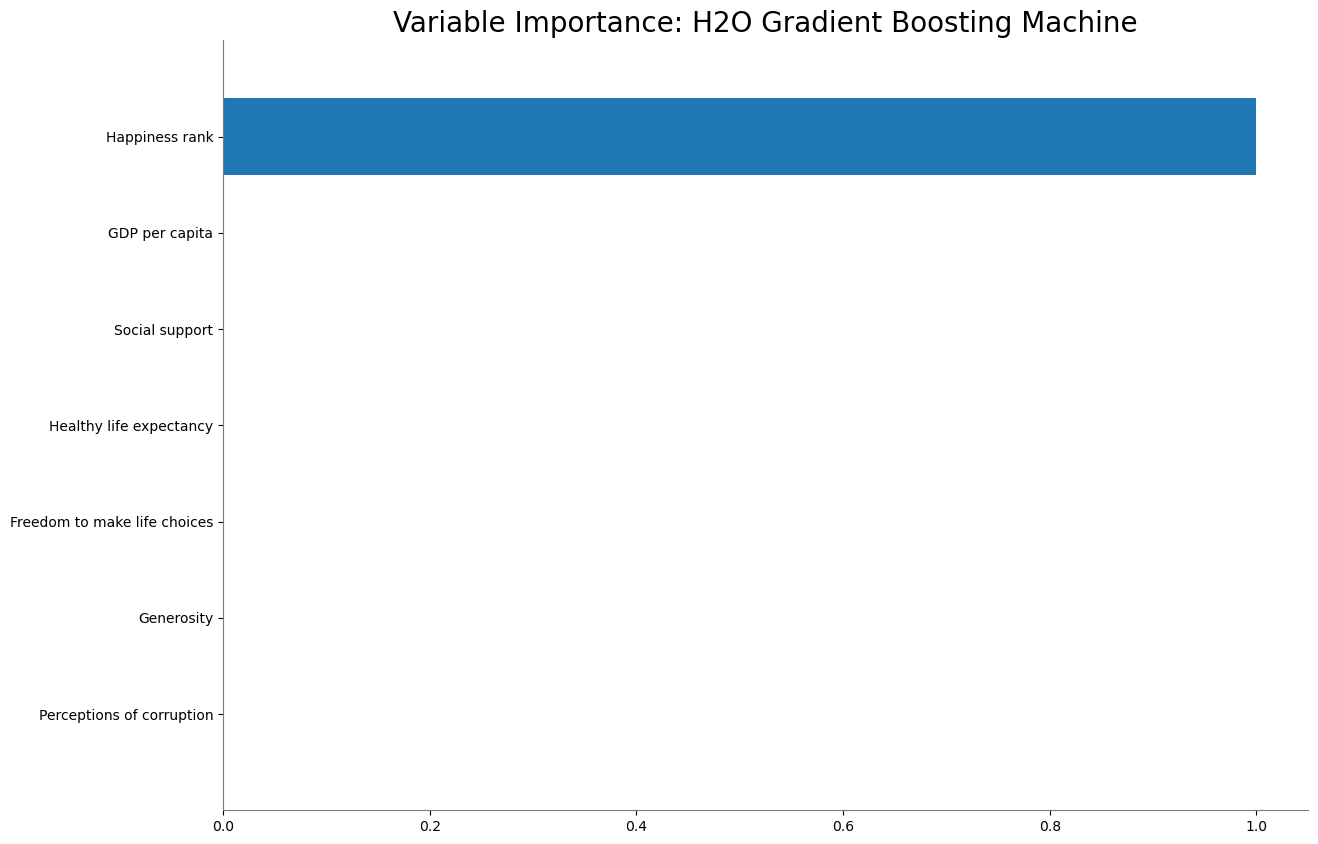

<Figure size 640x480 with 0 Axes>

In [24]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

In [25]:
# Model performance of GBM model on test data
data_gbm.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.5023195952685238
RMSE: 0.7087450848284761
MAE: 0.5008246220421837
RMSLE: 0.12923280239969417
Mean Residual Deviance: 0.5023195952685238

In [26]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [27]:
X=get_independent_variables(train, myY) 
print(X)
print(myY)

['Happiness rank', 'Year', 'Country', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
Happiness Score


In [28]:
print(train.columns)

['Country', 'Happiness rank', 'Happiness Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Year']


In [29]:
train.head()

Country,Happiness rank,Happiness Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Year
Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,2015
Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.4363,0.14145,2015
Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,2015
Norway,4,7.522,1.459,1.33095,0.88521,0.66973,0.34699,0.36503,2015
Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,2015
Finland,6,7.406,1.29025,1.31826,0.88911,0.64169,0.23351,0.41372,2015
Netherlands,7,7.378,1.32944,1.28017,0.89284,0.61576,0.4761,0.31814,2015
Sweden,8,7.364,1.33171,1.28907,0.91087,0.6598,0.36262,0.43844,2015
New Zealand,9,7.286,1.25018,1.31967,0.90837,0.63938,0.47501,0.42922,2015
Australia,10,7.284,1.33358,1.30923,0.93156,0.65124,0.43562,0.35637,2015


In [30]:
# Set up AutoML
run_time=333
aml = H2OAutoML(max_runtime_secs=run_time)

In [31]:
model_start_time = time.time()
  
aml.train(x=X,y=myY,training_frame=train) 

AutoML progress: |
14:33:51.912: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_lr_annealing_selection_AutoML_1_20221112_143351_select_model


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    80                 80                          99006                  7            13           9.625         51            61            55.35

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.00021706536046198097
RMSE: 0.014733138174264877
MAE: 0.008109423792954032
RMSLE: 0.0028702882657201246
Mean Residual Deviance: 0.00021706536046198097

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.004150120172275868
RMSE: 0.06442142634462442
MAE: 0.0480498407358366
RMSLE: 0.011752916340178216
Mean Residual Deviance: 0.004150120172275868

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0480526   0.00363525   0.0449235     0.0439891     0.0520665     0.0512841     0.0479996
mean_residual_deviance  0.00415274  0.00110235   0.00352284    0.00293579    0.00565125    0.00490861    0.00374521
mse                     0.00415274  0.00110235   0.00352284    0.00293579    0.00565125    0.00490861    0.00374521
r2                      0.996671    0.000911453  0.997233      0.997655      0.995454      0.996005      0.997008
residual_deviance       0.00415274  0.00110235   0.00352284    0.00293579    0.00565125    0.00490861    0.00374521
rmse                    0.0639942   0.0084769    0.0593535     0.054183      0.0751748     0.0700615     0.0611981
rmsle                   0.0115668   0.00238333   0.0102943     0.00898209    0.0150662     0.0127731     0.0107183

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2022-11-12 14:39:18  0.674 sec   0                  1.11814          0.93568         1.25023
    2022-11-12 14:39:18  0.694 sec   5                  0.665457         0.556168        0.442833
    2022-11-12 14:39:19  0.714 sec   10                 0.407515         0.339638        0.166068
    2022-11-12 14:39:19  0.734 sec   15                 0.256559         0.212917        0.0658227
    2022-11-12 14:39:19  0.754 sec   20                 0.166141         0.136894        0.0276027
    2022-11-12 14:39:19  0.772 sec   25                 0.110873         0.09015         0.0122929
    2022-11-12 14:39:19  0.792 sec   30                 0.0764621        0.0610548       0.00584645
    2022-11-12 14:39:19  0.814 sec   35                 0.0548814        0.0427427       0.00301197
    2022-11-12 14:39:19  0.835 sec   40                 0.0412261        0.0310305       0.00169959
    2022-11-12 14:39:19  0.857 sec   45                 0.032518         0.0235417       0.00105742
    2022-11-12 14:39:19  0.878 sec   50                 0.0268996        0.0186164       0.000723589
    2022-11-12 14:39:19  0.899 sec   55                 0.0231167        0.0153241       0.000534383
    2022-11-12 14:39:19  0.923 sec   60                 0.0204626        0.0129391       0.000418719
    2022-11-12 14:39:19  0.943 sec   65                 0.018702         0.011315        0.000349767
    2022-11-12 14:39:19  0.965 sec   70                 0.0171351        0.00998754      0.000293611
    2022-11-12 14:39:19  0.988 sec   75                 0.0156652        0.00889804      0.000245398
    2022-11-12 14:

In [32]:
execution_time = time.time() - model_start_time
print(execution_time)

686.5490961074829


In [33]:
print(aml.leaderboard)

model_id                                                               rmse         mse        mae      rmsle    mean_residual_deviance
GBM_lr_annealing_selection_AutoML_1_20221112_143351_select_model  0.0644214  0.00415012  0.0480498  0.0117529                0.00415012
StackedEnsemble_BestOfFamily_4_AutoML_1_20221112_143351           0.0645586  0.00416782  0.0483802  0.0118177                0.00416782
GBM_grid_1_AutoML_1_20221112_143351_model_77                      0.0647088  0.00418722  0.0476386  0.0117549                0.00418722
GBM_grid_1_AutoML_1_20221112_143351_model_121                     0.0661603  0.00437719  0.0479487  0.0120272                0.00437719
GBM_grid_1_AutoML_1_20221112_143351_model_217                     0.0669709  0.0044851   0.0482784  0.0123687                0.0044851
GBM_grid_1_AutoML_1_20221112_143351_model_305                     0.0670023  0.0044893   0.0499051  0.0123222                0.0044893
GBM_grid_1_AutoML_1_20221112_143351_model_222     

In [34]:
dir(aml)

['_H2OAutoML__frozen',
 '_H2OAutoML__input',
 '_H2OAutoML__validate_algo_parameters',
 '_H2OAutoML__validate_distribution',
 '_H2OAutoML__validate_frame',
 '_H2OAutoML__validate_modeling_plan',
 '_H2OAutoML__validate_monotone_constraints',
 '_H2OAutoML__validate_nfolds',
 '_H2OAutoML__validate_not_set',
 '_H2OAutoML__validate_preprocessing',
 '_H2OAutoML__validate_project_name',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algo_parameters',
 '_build_resp',
 '_custom_distribution_func',
 '_event_log',
 '_fetch',
 '_huber_alpha',
 '_job',
 '_leader_id',
 '_leaderboard',
 '_poll_training_updates',
 '_quantile_alpha',
 '_state_json',
 '_training_info',
 '_tweedie_powe

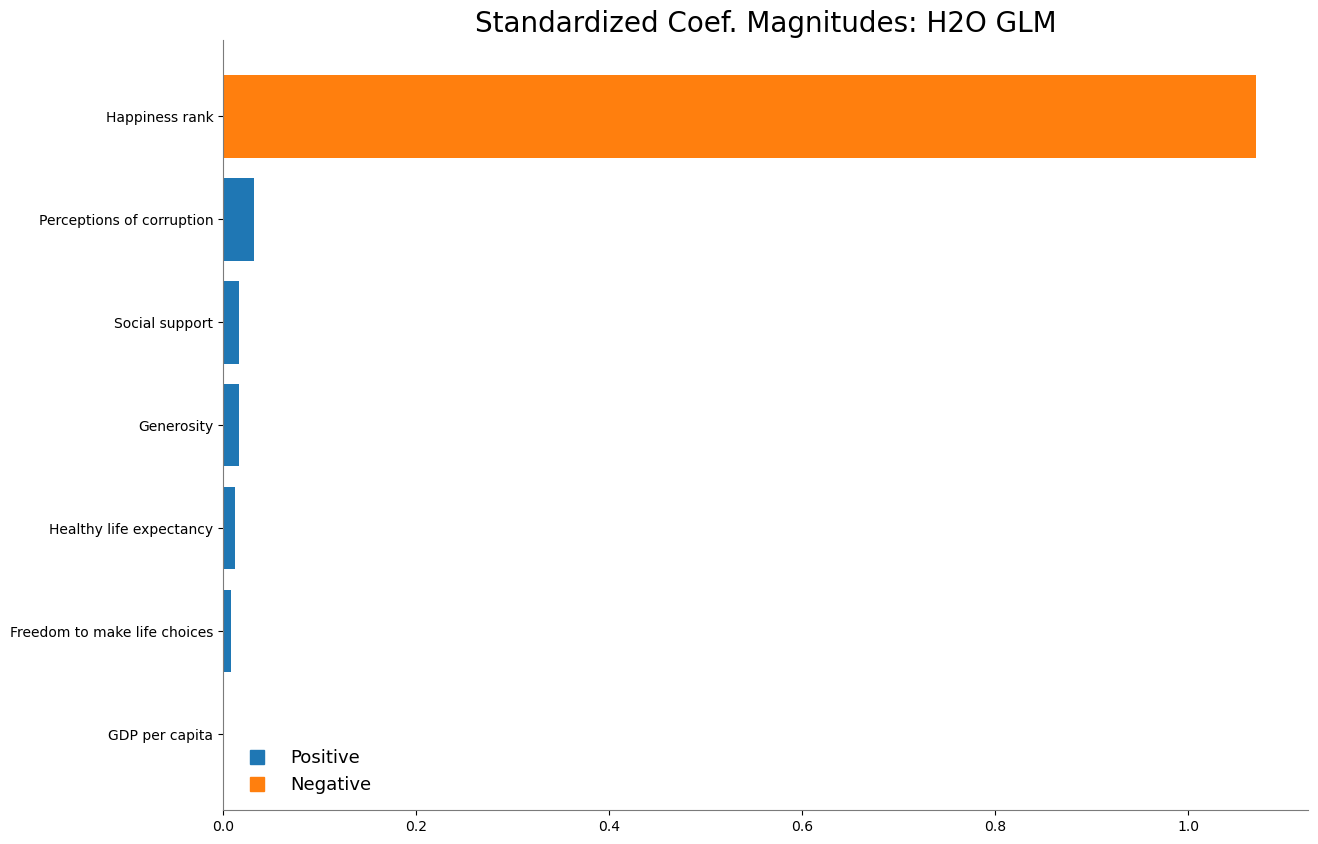

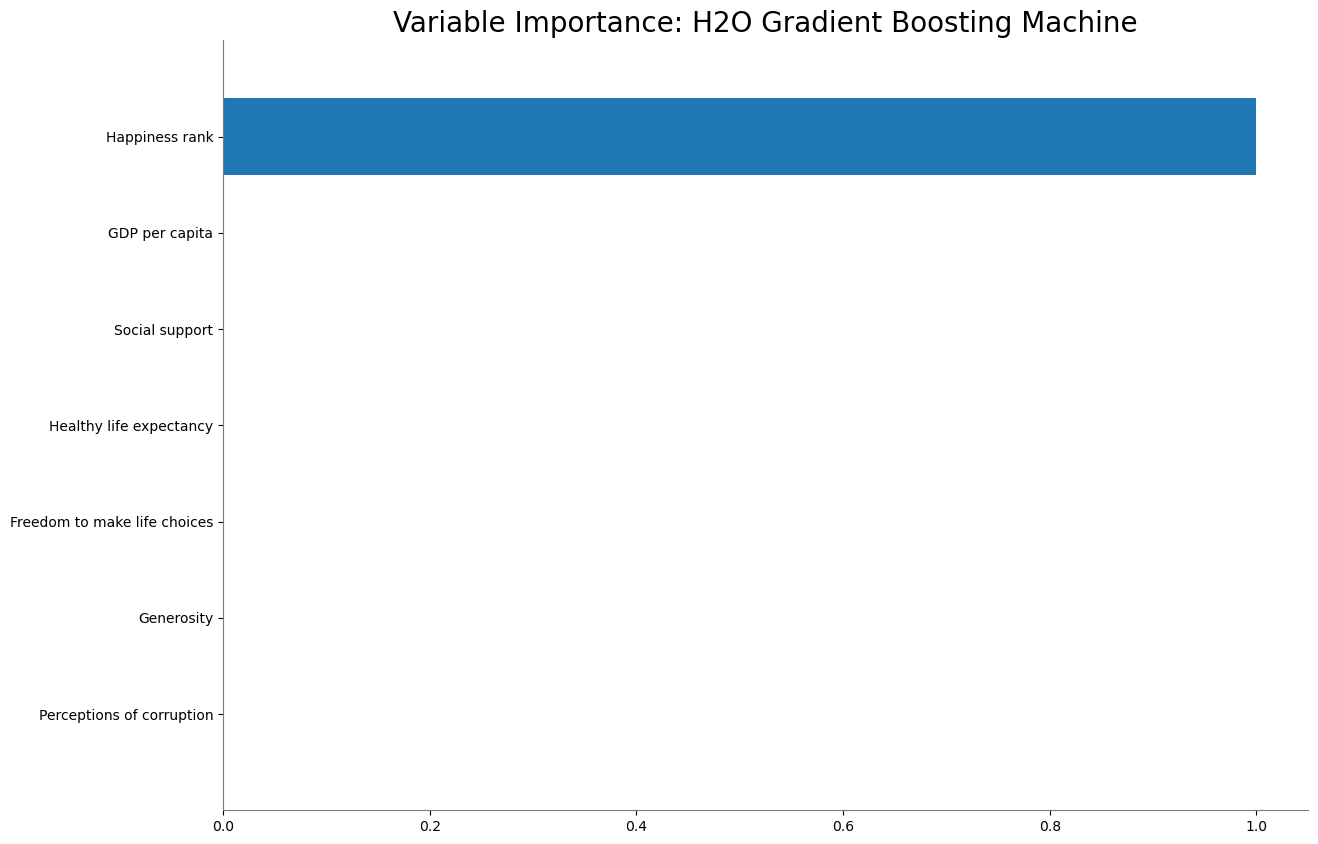

<Figure size 640x480 with 0 Axes>

In [35]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

In [36]:
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])

In [37]:
best_model.algo

'gbm'

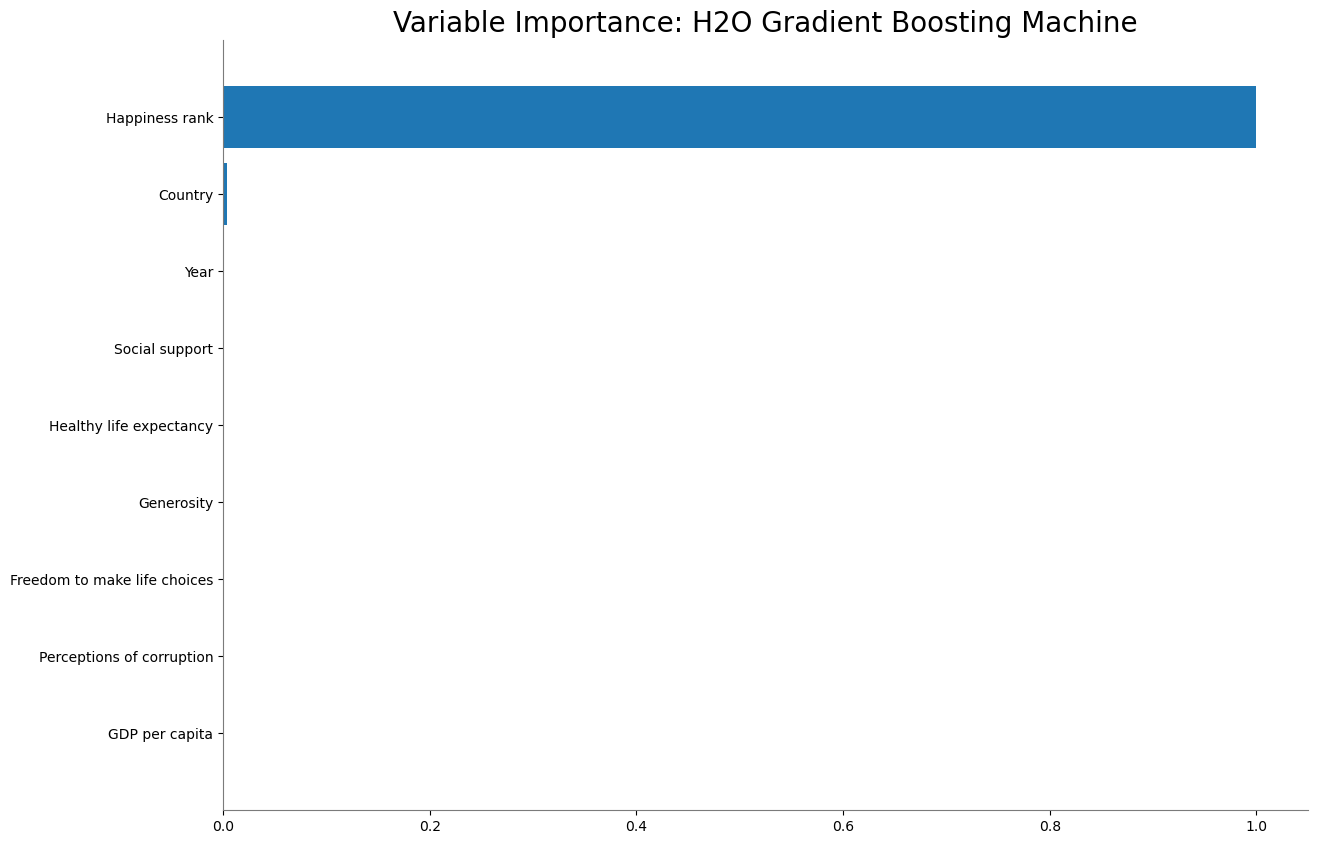

<Figure size 640x480 with 0 Axes>

In [38]:
if best_model.algo in ['xgboost','drf','gbm']:
  best_model.varimp_plot()

In [39]:
best_model.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_lr_annealing_selection_AutoML_1_20221112_143351_select_model',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_lr_annealing_selection_AutoML_1_20221112_143351_select_model'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20221112_143351_training_py_10_sid_b9da',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20221112_143351_training_py_10_sid_b9da'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20221112_143351_training_py_10_sid_b9da',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20221112_143351_training_py_10_sid_b9da'}},
 'validation_frame': {'default': None, 'actual': None, 'input':

In [41]:
h2o.cluster().shutdown()

H2O session _sid_b9da closed.
